In [357]:
import numpy as np 
import pandas as pd 
import duckdb as db
conn = db.connect()
import matplotlib.pyplot as plt

Read in main table:

In [358]:
apps = conn.execute(
    """
    DROP TABLE IF EXISTS apps;
    CREATE TABLE apps AS
        SELECT * FROM read_csv_auto('og_data/application_train.csv');
    SELECT * FROM apps;
    """
).fetchdf()

In [359]:
apps.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


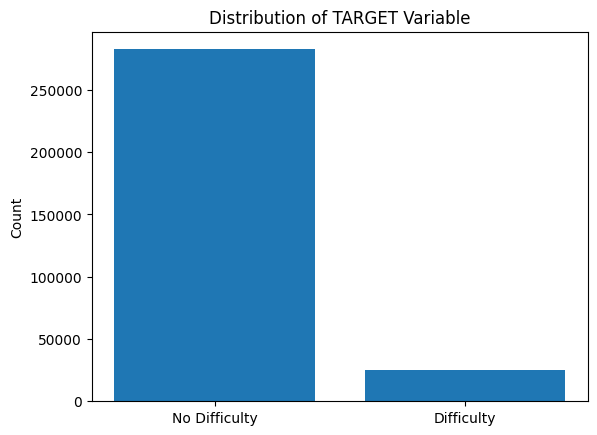

In [360]:
# plot value counts of TARGET column
target_counts = apps['TARGET'].value_counts()
plt.bar(target_counts.index, target_counts.values)
plt.xticks(target_counts.index, ['No Difficulty', 'Difficulty'])
plt.ylabel('Count')
plt.title('Distribution of TARGET Variable')
plt.show()

Very imbalanced, will have to consider oversampling or undersamping.

We noticed many columns are ful of missing values, so we will remove ones with a significant proportion missing. This will be focused on the positive class (minority) to preserve as much information as possible -- there should be enough from the majority class to match however much we end up having in the minority class.

But first, I'm going to try to fill in some of the missing entries that actually have meaning (e.g. missing a car-related variable means they don't own a car)

In [361]:
# when ext_source is missing, fill with mean of other ext_sources
ext_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
apps["EXT_SOURCE_MEAN"] = apps[ext_cols].mean(axis=1, skipna=True) # the mean itself could be useful as well
apps["EXT_SOURCE_MEAN"] = apps["EXT_SOURCE_MEAN"].fillna(apps["EXT_SOURCE_MEAN"].median()) # edge case where all 3 are missing
for col in ext_cols:
    apps[col] = apps[col].fillna(apps["EXT_SOURCE_MEAN"]) # fill missing sources with mean of all sources

# missing car age means they don't have a car
apps["HAS_CAR"] = (~apps["OWN_CAR_AGE"].isna()).astype(int) # flag indicating if they own a car
apps["OWN_CAR_AGE"] = apps["OWN_CAR_AGE"].fillna(0) # age = 0 = no car

# so many property-related columns where if missing, means they don't have that property
## current solution: a mean of proprerty-related columns and missingness proportion as features
property_cols = [c for c in apps.columns if "_AVG" in c or "_MEDI" in c or "_MODE" in c]
numeric_property_cols = apps[property_cols].select_dtypes(include=["number"]).columns
apps["PROPERTY_METRIC"] = apps[numeric_property_cols].mean(axis=1)
apps["PROPERTY_MISSING_PROP"] = apps[numeric_property_cols].isna().mean(axis=1)

# fill missing categorical property stuff with unknown (house type, wall material, etc.)
categorical_property_cols = apps[property_cols].select_dtypes(include=["object"]).columns
for col in categorical_property_cols:
    apps[col] = apps[col].fillna("UNKNOWN")

In [362]:
apps = apps.loc[:, apps[apps['TARGET'] == 1].isnull().mean() < 0.5]
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 82 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

Now the data is pretty much full except for a few columns. 

- `AMT_REQ_CREDIT_BUREAU_{}`
    - 0 means no credit checks
    - missing is different, it means they don't have info from the bureau on credit checks
    - fill in with 0 but also add a flag for missing?
    - and calculate total credit checks for a simpler feature
- `OCCUPATION_TYPE`
    - missing could be anything: unemployed, retired, student, just unknown...
    - could be meaningful, so don't remove
    - impute with 'unknown'
- **Social circle columns**
    - Small % of missing values, but only one left with any real amount of missing
    - Missing means no social data for this client
    - Reasonably fill with 0?

In [363]:
# bureau credit checks: add missing flag, impute with 0, and sum total requests
bureau_cols = [
    "AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"
]
apps["BUREAU_REQ_MISSING"] = apps[bureau_cols].isna().any(axis=1).astype(int)
apps[bureau_cols] = apps[bureau_cols].fillna(0)
apps["BUREAU_REQ_TOTAL"] = apps[bureau_cols].sum(axis=1, skipna=True)

# occupation type: impute with unknown
apps["OCCUPATION_TYPE"] = apps["OCCUPATION_TYPE"].fillna("Unknown")

# social circle columns: fill with 0
social_cols = [
    "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"
]
apps[social_cols] = apps[social_cols].fillna(0)
# calculate the default rates and totals for simple features
apps["SOCIAL_DEF_30_RATE"] = apps["DEF_30_CNT_SOCIAL_CIRCLE"] / (apps["OBS_30_CNT_SOCIAL_CIRCLE"] + 1e-5) # avoid div by 0
apps["SOCIAL_DEF_60_RATE"] = apps["DEF_60_CNT_SOCIAL_CIRCLE"] / (apps["OBS_60_CNT_SOCIAL_CIRCLE"] + 1e-5) # avoid div by 0
apps["SOCIAL_DEF_TOTAL"] = apps["DEF_30_CNT_SOCIAL_CIRCLE"] + apps["DEF_60_CNT_SOCIAL_CIRCLE"]
apps["SOCIAL_OBS_TOTAL"] = apps["OBS_30_CNT_SOCIAL_CIRCLE"] + apps["OBS_60_CNT_SOCIAL_CIRCLE"]

There should be so few missing values now that I think we just go ahead and drop them. The column with the most missing values now is only ~200 out of ~300k, so dropping rows with missing values is pretty negligable. 

In [364]:
apps = apps.dropna()
apps.TARGET.value_counts()

TARGET
0    281451
1     24755
Name: count, dtype: int64

In [365]:
apps.to_csv('data/apps_cleaned.csv', index=False)